In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

In [3]:
from BHDVCStf import BHDVCS

In [4]:
bhdvcs = BHDVCS()

In [168]:
data = pd.read_csv('dvcs_psuedo.csv')

# For Set 0

In [18]:
data = data.loc[(data['#Set'] == 0) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [19]:
def produceLHS(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    interference = data['F'] - data['dvcs'] - bh
    interference /= bhdvcs.Gamma
    interference *= data['QQ']
    interference *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    interference /= b
    return interference

In [161]:
def produceLHSerr(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    err = data['errF']
    err /= bhdvcs.Gamma
    err *= data['QQ']
    err *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    err /= b
    return np.abs(err)

In [9]:
def aoverb(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    return a/b

In [169]:
produceLHSerr(data, bhdvcs)

0      1.289893
1      1.284265
2      1.728553
3      2.162472
4      2.951399
         ...   
535    6.854177
536    5.346418
537    4.031707
538    2.879922
539    2.633917
Name: errF, Length: 540, dtype: float64

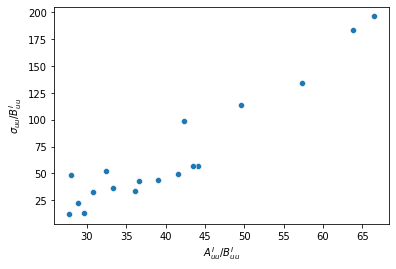

In [10]:
sns.scatterplot(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs))
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

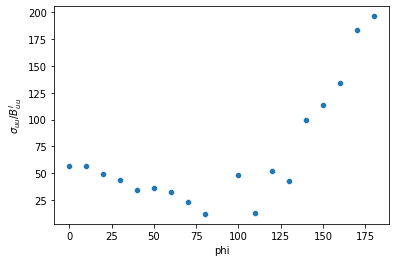

In [11]:
sns.scatterplot(x=data['phi_x'], y=produceLHS(data, bhdvcs))
plt.xlabel('phi')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

In [12]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
err = produceLHSerr(data, bhdvcs)

In [13]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.ABcon(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [20]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

### Fitted Compton Form Factors

In [21]:
cffs

array([ 16.20321612, -70.95512652])

In [22]:
np.diag(var)

array([ 12.7743163 , 337.41543006])

### True CFFs

In [23]:
data.loc[0, ['ReH', 'ReE']]

ReH    13.0554
ReE   -53.0554
Name: 0, dtype: float64

In [24]:
yhat = linear_curve_fit(X, *cffs)
yhatupper = linear_curve_fit(X, *(cffs + np.diag(var)))
yhatlower = linear_curve_fit(X, *(cffs - np.diag(var)))

In [25]:
yhatwtrue = linear_curve_fit(X, 13.0554, -53.0554)

### Central Values

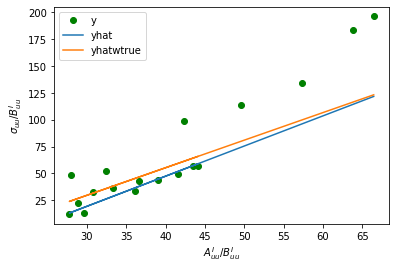

In [26]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Error from variance

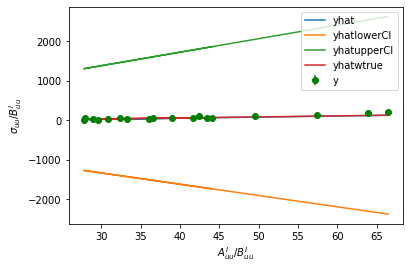

In [27]:
plt.errorbar(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), yerr=err, fmt='go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatlower, label='yhatlowerCI')
plt.plot(aoverb(data, bhdvcs), yhatupper, label='yhatupperCI')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Limits

In [140]:
high = data.copy()
high['F'] = data['F'] + data['errF']
low = data.copy()
low['F'] = data['F'] - data['errF']

In [141]:
high

,#Set,index,errF,F,phi_x,QQ,x_b,t,k,F1,F2,dvcs,ReH,ReE,ReHtilde
0,0,0,25081.524489,25138.168588,0,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
1,0,1,26351.191492,26408.281825,10,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
2,0,2,25735.520380,25784.978030,20,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
3,0,3,27506.073129,27549.801901,30,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
4,0,4,27565.719183,27599.769229,40,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,14,31,205922.720357,205958.766365,310,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
536,14,32,163100.166302,163138.850578,320,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
537,14,33,166251.770829,166301.670076,330,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
538,14,34,181674.765242,181739.540946,340,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283


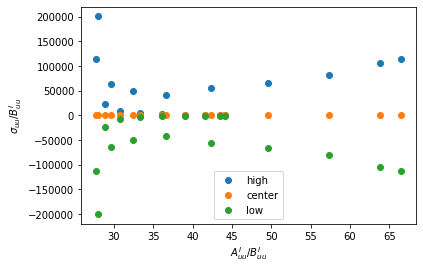

In [25]:
plt.scatter(x=aoverb(high, bhdvcs), y=produceLHS(high, bhdvcs), label='high')
plt.scatter(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs), label='center')
plt.scatter(x=aoverb(low, bhdvcs), y=produceLHS(low, bhdvcs), label='low')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Error from limits

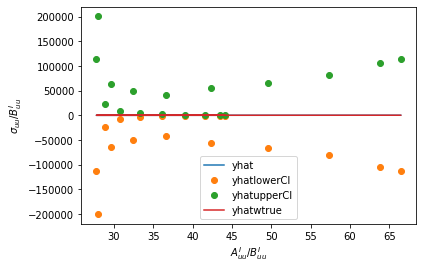

In [37]:
#plt.errorbar(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), yerr=err, fmt='go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(low, bhdvcs), produceLHS(low, bhdvcs), 'o', label='yhatlowerCI')
plt.plot(aoverb(high, bhdvcs), produceLHS(high, bhdvcs), 'o', label='yhatupperCI')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## A/B vs phi

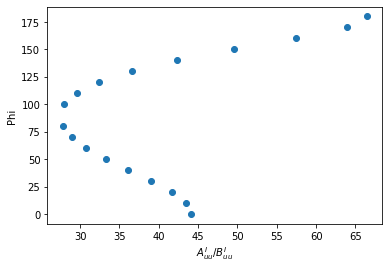

In [23]:
plt.scatter(aoverb(data, bhdvcs), data['phi_x'])
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('Phi')
plt.show()

# New Error

In [149]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
high = data.copy()
high['F'] = data['F'] + data['errF']
err = np.abs(produceLHS(high, bhdvcs) - y)

In [152]:
err = produceLHSerr(data, bhdvcs)

In [153]:
err

0     -1.111674e+07
1     -1.217419e+07
2     -1.340869e+07
3     -1.732759e+07
4     -2.236163e+07
           ...     
535   -1.177134e+09
536   -6.880892e+08
537   -5.541644e+08
538   -5.096921e+08
539   -4.176683e+08
Name: errF, Length: 540, dtype: float64

In [150]:
err

0      1.111674e+07
1      1.217419e+07
2      1.340869e+07
3      1.732759e+07
4      2.236163e+07
           ...     
535    1.177134e+09
536    6.880892e+08
537    5.541644e+08
538    5.096921e+08
539    4.176683e+08
Length: 540, dtype: float64

In [60]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

In [61]:
cffs

array([-4.14998417, 30.11224422])

$$\frac{g_1(b)}{1−G_1(b)} > \frac{g_2(b)}{1−G_2(b)}$$

In [ ]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

# Simultaneous

In [38]:
import BHDVCStf

In [39]:
import utilities

In [103]:
def combined_function(data, ReH, ReE, ReHtilde):
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    y1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    y2 = linear_curve_fit(X, ReH, ReE)
    return np.array((y1 + y2)/2)

In [163]:
data = pd.read_csv('dvcs_psuedo.csv')

In [164]:
data['F'] = produceLHS(data, bhdvcs)

In [124]:
#data = data.loc[(data['#Set'] == 0) &(data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [165]:
high = data.copy()
high['F'] = high['F'] + high['errF']
data['errF'] = np.abs(produceLHS(high, bhdvcs) - data['F'])

In [167]:
data['errF'].describe()

count    5.400000e+02
mean     1.771357e+23
std      1.110558e+24
min      2.478243e+01
25%      5.754376e+04
50%      1.466405e+05
75%      5.665330e+05
max      1.004347e+25
Name: errF, dtype: float64

In [108]:
combined_function(data, 1., 1., 20.)

array([ 14.27053015,  14.18726434,  13.97456414,  13.7323913 ,
        13.59776836,  13.72086449,  14.25384534,  15.35368962,
        17.19516441,  24.01063197,  29.61165748,  37.24188467,
        47.40651283,  60.49420681,  76.30235026,  93.13221648,
       106.95007874, 112.4407308 ])

In [109]:
from tqdm import tqdm

In [125]:
data['#Set'] == 1

0      False
1      False
2      False
3      False
4      False
       ...  
535    False
536    False
537    False
538    False
539    False
Name: #Set, Length: 540, dtype: bool

In [126]:
def produceResults(data, numSets, numReplicas):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    for i in tqdm(range(numSets)):
        seti = data.loc[(data['#Set'] == i) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]
        replicas = []
        #X = np.array(seti.XnoCFF) # the kinematics and all variables necessary to compute 
        #sigma = seti.erry 
        pars = np.array([1, 1, 1])
        for i in range(numReplicas):
            #y = seti.sampleY()
            cff, cffcov = optimize.curve_fit(combined_function, seti, seti['F'], pars, method='lm')
            replicas.append(cff)
        results.append(replicas)
    return np.array(results)

In [127]:
results = produceResults(data, 15, 1)

100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


In [130]:
import utilities as uts

In [128]:
results

array([[[ 16.30423061, -69.41427772,  14.53272129]],

       [[ 10.87657055, -42.81350307,  17.44531023]],

       [[ 14.82059675, -90.98633502,   6.74455017]],

       [[  7.83834603, -48.76886673,  11.82091091]],

       [[ 11.1320966 , -44.77613848,  16.69952691]],

       [[ 12.50846623, -77.41568167,  11.47291749]],

       [[  7.74234075, -29.42764557,  12.30594132]],

       [[  7.64809465, -47.80104637,  11.84592268]],

       [[ 11.13608109, -44.92137225,  16.45161324]],

       [[  4.78332034, -33.01181371,   5.1336337 ]],

       [[ 11.87682657, -73.76801399,  13.55402647]],

       [[  9.42369547, -39.16396523,   9.65793736]],

       [[  4.76475462, -32.93374781,   4.58326562]],

       [[ 11.84720904, -73.58708731,  15.12716811]],

       [[  9.99299852, -42.35472259,   8.38951505]]])

In [142]:
data

,#Set,index,errF,F,phi_x,QQ,x_b,t,k,F1,F2,dvcs,ReH,ReE,ReHtilde
0,0,0,25081.524489,56.644099,0,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
1,0,1,26351.191492,57.090333,10,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
2,0,2,25735.520380,49.457650,20,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
3,0,3,27506.073129,43.728771,30,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
4,0,4,27565.719183,34.050046,40,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,14,31,205922.720357,36.046007,310,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
536,14,32,163100.166302,38.684276,320,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
537,14,33,166251.770829,49.899246,330,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
538,14,34,181674.765242,64.775703,340,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283


In [133]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 0)

Mean percent error:  28.10510889888377
RMSE:  3.467259854776928
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -0.884910856650496


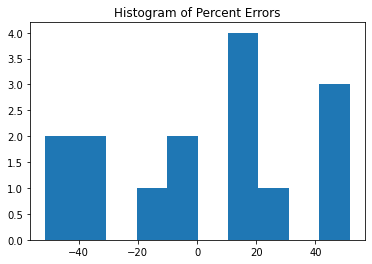

In [135]:
uts.evaluate(y_yhat)

In [136]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 1)

Mean percent error:  30.48759203241225
RMSE:  19.741552613266293
RMSE w yhat=mean:  2.525480507907797
R-squared:  -60.104693417140794


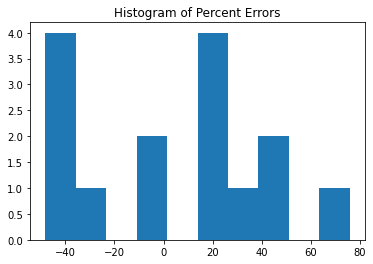

In [137]:
uts.evaluate(y_yhat)

In [138]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 2)

Mean percent error:  49.65253896508765
RMSE:  7.249909738406301
RMSE w yhat=mean:  1.4030345621243816
R-squared:  -25.701057391692828


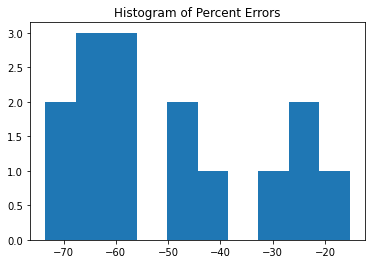

In [139]:
uts.evaluate(y_yhat)